# Trees Lab

Review Scikit-Learn [Decision Trees](https://scikit-learn.org/stable/modules/tree.html).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from IPython.display import Image
import pandas as pd
from functools import reduce
from xgboost import XGBClassifier
import gdown
import pydotplus
from tqdm import tqdm

# Decision Trees

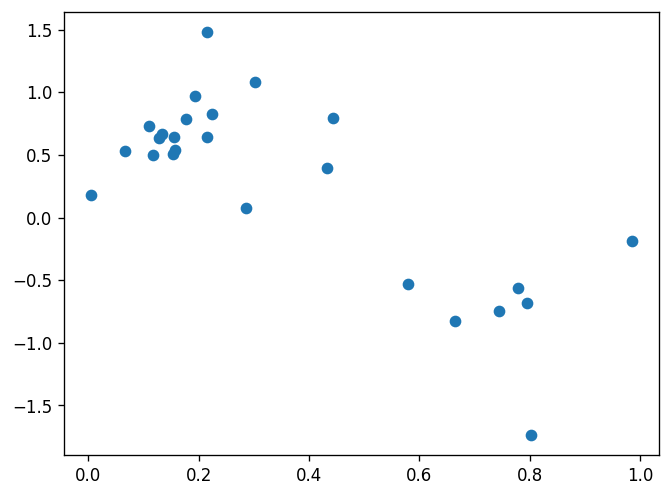

In [8]:
# Make some fake data
def make_regression_data(n=25):
    x = np.random.uniform(size = (n,1))
    e = np.random.normal(0, 0.3, size = x.shape) # some noise
    y = np.sin(2*np.pi*x) + e
    return (x, y.ravel())

x,y = make_regression_data()
fig, ax = plt.subplots(dpi = 120)
plt.scatter(x,y)
plt.show()

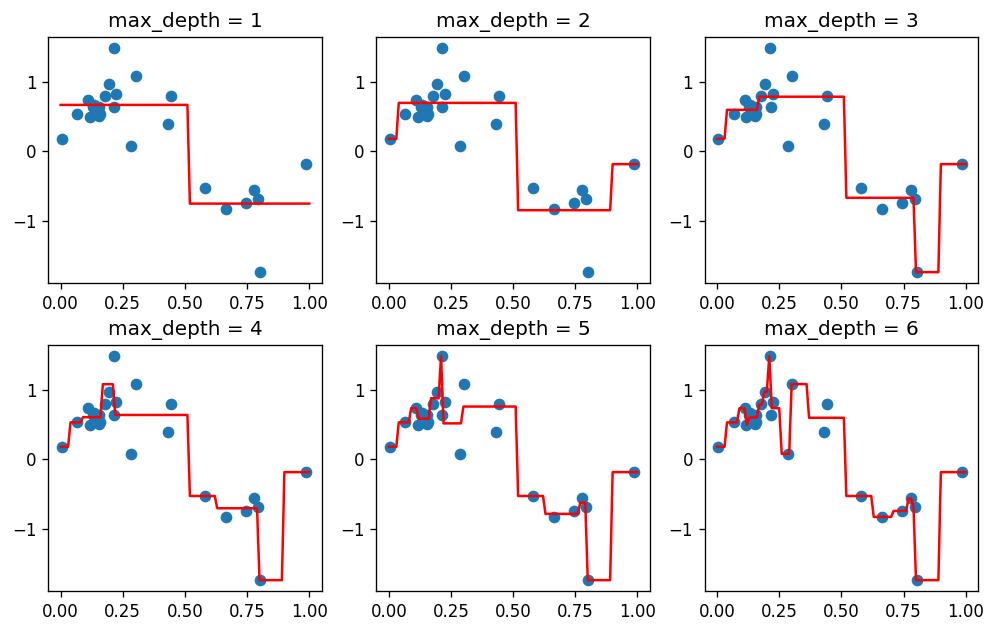

In [9]:
# Fit a regression tree to this data
# With varying max depth
# To see how this tree grows

depths = np.arange(1,7)
fig, ax = plt.subplots(dpi = 120, nrows = 2, ncols = 3, figsize = (10,6))
plt.subplots_adjust(hspace=0.25)
ax = ax.ravel() #flattens the ax variable

newx = np.linspace(0,1,101).reshape(-1,1)

for d,a in zip(depths, ax):
    reg = DecisionTreeRegressor(max_depth=d)
    reg.fit(x,y)
    
    ypred = reg.predict(newx)
    a.scatter(x,y)
    a.plot(newx, ypred, color = 'red')
    a.set_title(f'max_depth = {d}')

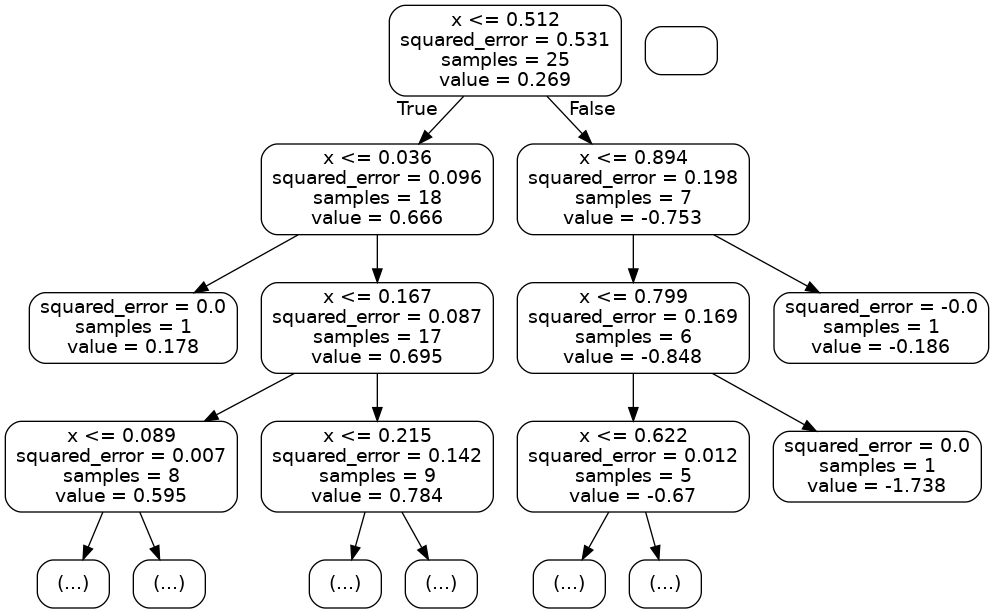

In [10]:
# Create DOT data
dot_data = export_graphviz(reg, out_file=None, rounded = True, max_depth=3, feature_names=['x'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

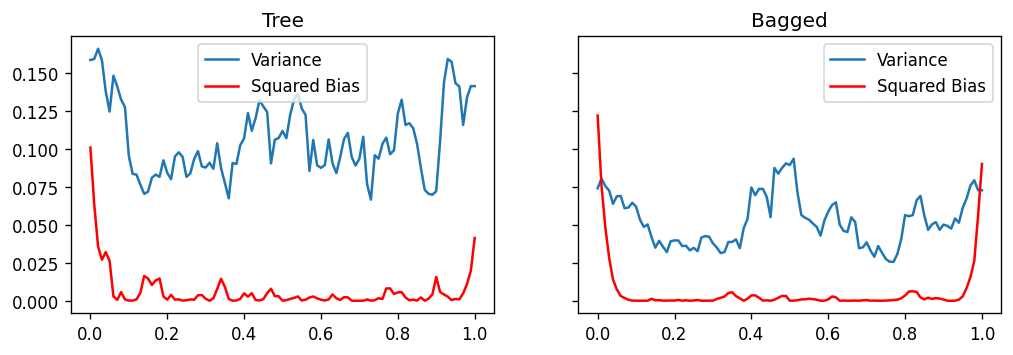

In [11]:
# Let's compare variance of predictions between a tree and a bagged estimator

# Create a tree model and a bagging from these trees
newx = np.linspace(0,1,101).reshape(-1,1)
tree = DecisionTreeRegressor(max_depth = 5)
bag1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth = 5), n_estimators=100, n_jobs = -1)

models = [tree, bag1]
model_names = ['Tree', "Bagged"]

# Create two plots, one for the tree, one for the bagging
fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols = len(models), figsize = (10,3), sharey = True)
ax = ax.ravel() #flattens the ax variable

# Generate 500 runs for each model and calculate bias and variance. This takes a while!
nsim = 50

for axis, model, name in zip(ax, models, model_names):
    
    #Store the predictions somewhere
    predictions = np.zeros((nsim, newx.shape[0]))
    
    for i in range(nsim):
        x,y = make_regression_data()
        model.fit(x,y)
        ypred = model.predict(newx)
        predictions[i] = ypred
        
    #Plot the variance
    axis.plot(newx, predictions.var(axis = 0), label = 'Variance')
    
    #Plot the bias
    bias = (predictions - np.sin(2*np.pi*newx.T)).mean(axis = 0)**2
    axis.plot(newx, bias, color = 'red', label = 'Squared Bias')
    axis.set_title(name)
    axis.legend()

The following cell is just an expanded version of the previous cell to make it easier to follow, otherwise they do the same thing.

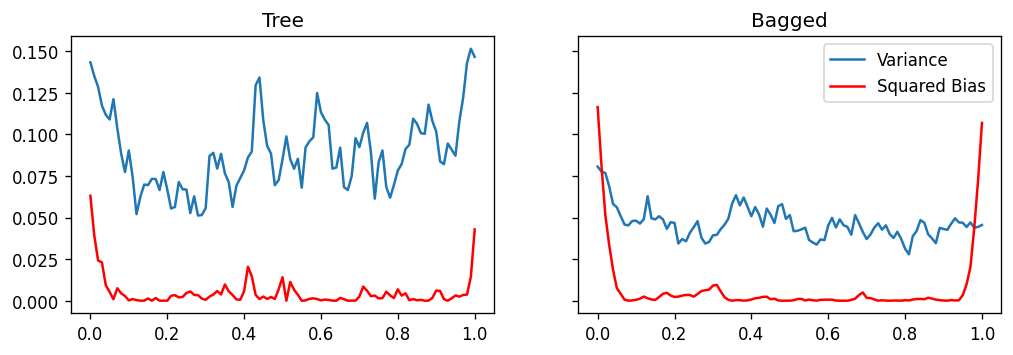

In [12]:
# Let's compare variance of predictions between a tree and a bagged estimator
newx = np.linspace(0,1,101).reshape(-1,1)

# Generate `nsim` runs for each model and calculate bias and variance. This takes a while!
nsim = 50

# Create two plots, one for the tree, one for the bagging
fig, ax = plt.subplots(dpi=120, nrows=1, ncols=len(models), figsize=(10,3), sharey=True)


################################################### 1st figure
# Create a simple tree model
tree = DecisionTreeRegressor(max_depth=5)
# Initialize an array for predictions
predictions = np.zeros((nsim, newx.shape[0]))

for i in range(nsim):
    x, y = make_regression_data() # every time get new data from the same data generating process
    tree.fit(x,y)
    ypred = tree.predict(newx) # here ypred is coming directly from the terminal 
                               # nodes of the single tree fitted to x and y
    predictions[i] = ypred
    
#Plot the variance
ax[0].plot(newx, predictions.var(axis = 0), label = 'Variance')

#Plot the bias
bias = (predictions-np.sin(2*np.pi*newx.T)).mean(axis = 0)**2
ax[0].plot(newx, bias, color = 'red', label = 'Squared Bias')
ax[0].set_title('Tree')


################################################### 2nd figure
# Create a bagging model
bag = BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, n_jobs=-1)
# Initialize an array for predictions
predictions = np.zeros((nsim, newx.shape[0]))

for i in range(nsim):
    x, y = make_regression_data() # every time get new data from the same data generating process
    bag.fit(x,y)
    ypred = bag.predict(newx) # here ypred is coming from averaging individual predictions of
                              # random subsets of the original dataset (one tree per random subset)
    predictions[i] = ypred
    
#Plot the variance
ax[1].plot(newx, predictions.var(axis = 0), label = 'Variance')

#Plot the bias
bias = (predictions-np.sin(2*np.pi*newx.T)).mean(axis=0)**2
ax[1].plot(newx, bias, color = 'red', label = 'Squared Bias')
ax[1].set_title('Bagged')
ax[1].legend()

plt.show()